In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time

#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

In [2]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [3]:
def sample_from_logreg(p=20, n=500, seed=984):
    np.random.seed(seed)
    X = np.random.normal(0, 1, size=(n, p))  # sample (n, p) from standard normal

    theta_star = np.zeros(p).reshape(-1, 1)
    non_zero = p//5
    #non_zero = p//2
    for i in np.random.choice(p, non_zero):
        theta_star[i] = np.random.normal(0, 1)

    probs = np.exp(X @ theta_star) / (np.exp(X @ theta_star) + 1)
    y = np.zeros(n)

    for i in range(0, n):
        y[i] = np.random.binomial(1, *probs[i])

    return (X, theta_star, y)

In [4]:
def l(X, y, theta):
    return -y @ np.log(sigmoid(X @ theta)) - (1 - y) @ np.log(1 - sigmoid(X @ theta)) + np.linalg.norm(theta, 1)

In [5]:
def nabla_l(X, y, theta):
    return -X.T @ y + (X.T @ sigmoid(X @ theta)).ravel()

In [6]:
def nabla_l_i(X, y, theta):
    return -X * y + X * sigmoid(X @ theta)

In [7]:
def hess_l(X, y, theta):
    return (X.T * (sigmoid(X @ theta) * (1 - sigmoid(X @ theta))) @ X)

In [8]:
n = 500
p = 50
X, theta_star, y = sample_from_logreg(p=p, n=n)

In [9]:
def experiment(update_rule, n_iter=50, **kwargs):
    theta = np.zeros(p)
    losses = np.zeros(n_iter)
    grad = np.zeros(n_iter)
    losses[0] = l(X, y, theta)
    for i in range(n_iter):
        losses[i] = l(X, y, theta)
        grad[i] = np.linalg.norm(nabla_l(X, y, theta), 2)
        theta = update_rule(X, y, theta, **kwargs)
    return (losses, theta)

In [10]:
n_iter = 50

In [11]:
def gd_update(X, y, theta, eta=0.01):
    return theta - eta * nabla_l(X, y, theta)

t1 = time.time()
gd_loss, gd_theta = experiment(gd_update, n_iter=n_iter)
t2 = time.time()
print(t2 - t1)

0.007986307144165039


In [12]:
def ns_update(X, y, theta):
    return theta - (np.linalg.inv(hess_l(X, y, theta)) @ nabla_l(X, y, theta))

ns_loss, ns_theta = experiment(ns_update, n_iter=n_iter)

In [13]:
def sgd_update(X, y, theta, eta=0.01, batch_size=100):
    i = np.random.choice(X.shape[0], size=batch_size)
    theta -= eta * nabla_l(X[i], y[i], theta)
    return theta 


t1 = time.time()
sgd_loss, sgd_theta = experiment(sgd_update, n_iter=n_iter)
t2 = time.time()
print(t2 - t1)

0.008364200592041016


In [14]:
soft_thresholding = lambda theta, lbd: np.sign(theta) * np.fmax(np.zeros(theta.shape[0]), np.abs(theta) - lbd)
    
def proxgd_update(X, y, theta, eta=0.01, lbd=0.1):
    return soft_thresholding(theta - eta * nabla_l(X, y, theta), lbd)

proxgd_loss, lasso_theta = experiment(proxgd_update, n_iter=n_iter)
print(lasso_theta)
print(len(np.where(lasso_theta != 0)[0]))

[ 0.          0.03249138 -0.         -0.92835358  0.          0.95638322
 -0.1026939  -0.          0.          0.          0.19483907  0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.         -0.          0.         -0.
 -0.         -0.02872665  0.          0.          1.53921551  0.
  0.         -0.          0.         -0.13593123  0.         -0.
 -0.          0.1695737  -0.         -0.00900258 -0.08389188 -0.
 -0.          0.31544528  0.          0.         -0.         -0.
 -0.         -0.        ]
12


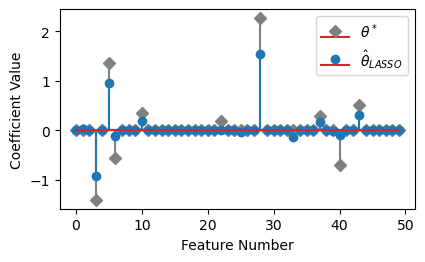

In [15]:
fig, ax = plt.subplots()
ax.stem(theta_star, linefmt='grey', markerfmt='D', label="$\\theta^*$")
ax.stem(lasso_theta, label="$\hat{\\theta}_{LASSO}$")
ax.set_xlabel("Feature Number")
ax.set_ylabel("Coefficient Value")
ax.legend()
ws = 1.25
hs = 1.35
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
#plt.savefig('theta_lasso_sparsity.pgf', bbox_inches='tight', pad_inches=0)

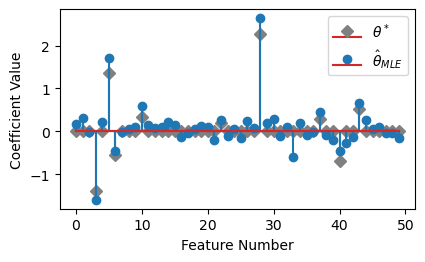

In [16]:
fig, ax = plt.subplots()
ax.stem(theta_star, linefmt='grey', markerfmt='D', label="$\\theta^*$")
ax.stem(gd_theta, label="$\hat{\\theta}_{MLE}$")
ax.set_xlabel("Feature Number")
ax.set_ylabel("Coefficient Value")
ax.legend()
ws = 1.25
hs = 1.35
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
#plt.savefig('theta_mle_sparsity.pgf', bbox_inches='tight', pad_inches=0)

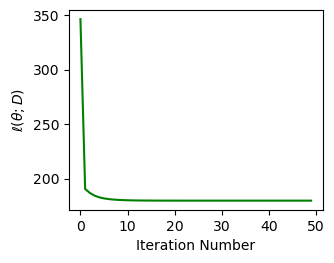

In [17]:
fig, ax = plt.subplots()
ax.plot(proxgd_loss, label="ISTA", c='g')
#ax.set_ylabel('$\ell(\\theta; D)$', rotation=0, labelpad=20)
ax.set_ylabel('$\ell(\\theta; D)$')
ax.set_xlabel('Iteration Number')
ws = 1.75
hs = 1.35
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
#plt.savefig('ista_loss.pgf', bbox_inches='tight', pad_inches=0)

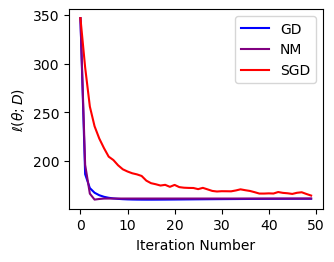

In [18]:
fig, ax = plt.subplots()
ax.plot(gd_loss, label="GD", c='b')
ax.plot(ns_loss, label="NM", c='purple')
ax.plot(sgd_loss, label="SGD", c='r')
#ax.set_ylabel('$\ell(\\theta; D)$', rotation=0, labelpad=20)
ax.set_ylabel('$\ell(\\theta; D)$')
ax.set_xlabel('Iteration Number')
ax.legend()
ws = 1.75
hs = 1.35
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
#plt.savefig('all_loss.pgf', bbox_inches='tight', pad_inches=0)